<a href="https://colab.research.google.com/github/venkatesh-r96/Image_classification_potato/blob/main/Image_classification_potato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers

In [ ]:
!nvidia-smi

Wed Aug 30 09:09:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Image_size = 256
Batch_size = 32
Channels = 3
Epochs = 50

In [ ]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data Science/potato",
    shuffle=True,
    image_size=(Image_size, Image_size),
    batch_size = Batch_size)


Found 2162 files belonging to 3 classes.


In [ ]:
class_names = df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(df)

68

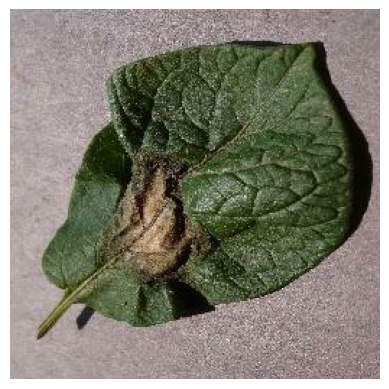

In [ ]:
for image_batch, label_batch in df.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.axis("off")

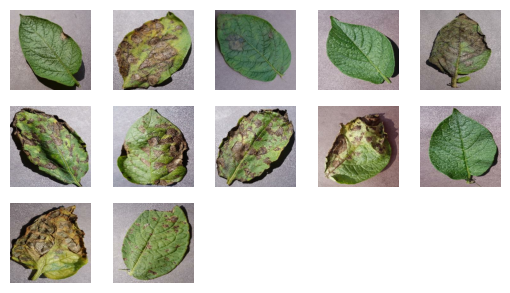

In [ ]:
for image_batch, label_batch in df.take(1):
  for i in range(12):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(image_batch[i].numpy(). astype("uint8"))
    plt.axis("off")

In [ ]:
len(df)

68

In [ ]:
# 80% = training
# 20% => 10% validation, 10% test

train_size = 0.8
len(df)*train_size

54.400000000000006

In [ ]:
train_ds = df.take(54)
len(train_ds)

54

In [ ]:
test_ds = df.skip(54)
len(test_ds)

14

In [ ]:
val_size = 0.1
len(df)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size=10000):
  ds_size= len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed =12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [ ]:
len(train_ds)

54

In [ ]:
len(test_ds)

8

In [ ]:
len(val_ds)

6

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size, Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_agumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (Batch_size, Image_size, Image_size, Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_agumentation,
    layers.Conv2D(32, (3,3), activation= 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = Epochs,
    batch_size = Batch_size,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 15s 141ms/step - loss: 0.7912 - accuracy: 0.5868 - val_loss: 0.7322 - val_accuracy: 0.6719
Epoch 2/50
54/54 [==============================] - 3s 62ms/step - loss: 0.4998 - accuracy: 0.7905 - val_loss: 0.4401 - val_accuracy: 0.7760
Epoch 3/50
54/54 [==============================] - 3s 64ms/step - loss: 0.3469 - accuracy: 0.8559 - val_loss: 0.3667 - val_accuracy: 0.8177
Epoch 4/50
54/54 [==============================] - 3s 61ms/step - loss: 0.2646 - accuracy: 0.8808 - val_loss: 0.1963 - val_accuracy: 0.9479
Epoch 5/50
54/54 [==============================] - 3s 61ms/step - loss: 0.1766 - accuracy: 0.9300 - val_loss: 0.2398 - val_accuracy: 0.9115
Epoch 6/50
54/54 [==============================] - 3s 62ms/step - loss: 0.1554 - accuracy: 0.9387 - val_loss: 0.1442 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 3s 65ms/step - loss: 0.1282 - accuracy: 0.9531 - val_loss: 0.1364 - val_accuracy: 0.9531
Epoch 8/50


In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 0s 28ms/step - loss: 0.0621 - accuracy: 0.9766


In [ ]:
scores

[0.062127646058797836, 0.9765625]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

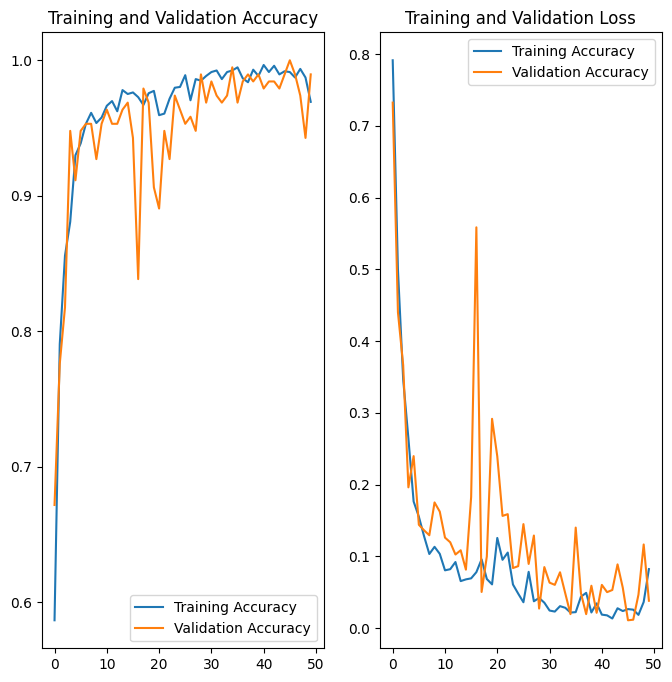

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs), acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(Epochs), loss, label = 'Training Accuracy')
plt.plot(range(Epochs), val_loss, label = 'Validation Accuracy')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 54ms/step
predicted label: Potato___Early_blight


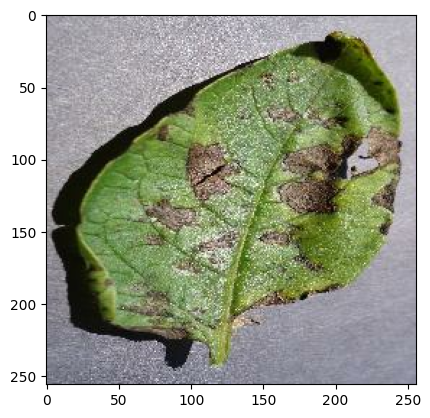

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round (100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


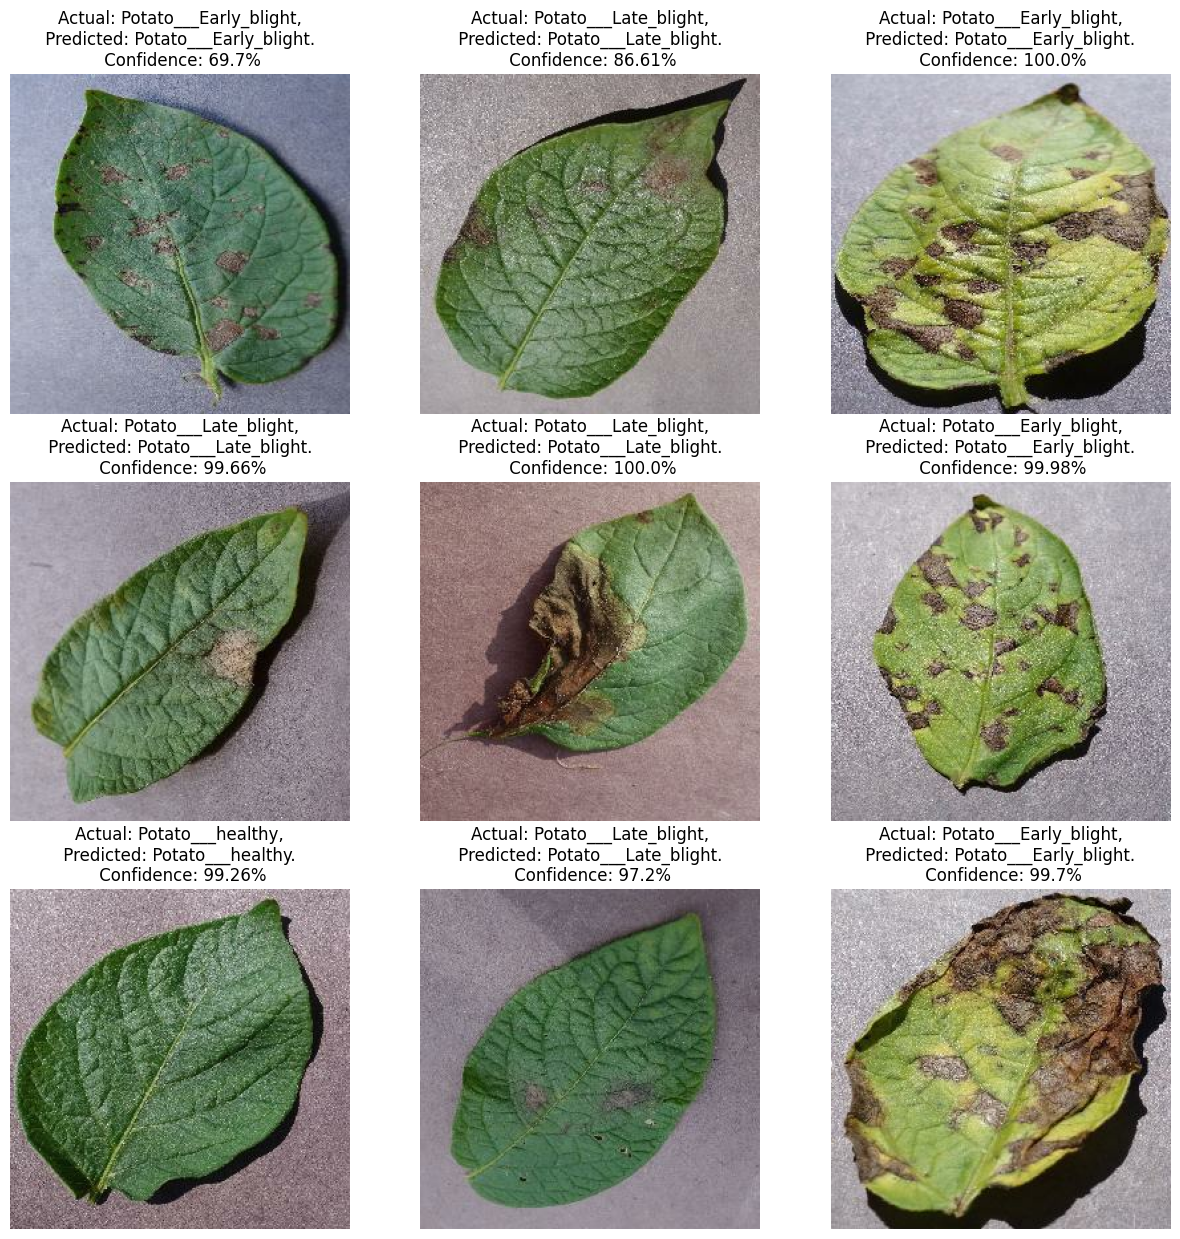

In [ ]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}. \n Confidence: {confidence}%")
    plt.axis("off")


# It showing my model prediction is good